# Código Arbol de decisión para clasificación
POr Liceth Mosquera

## Librerias necesarias

In [1]:
# Imports needed for the script
import numpy as np
import pandas as pd
import itertools as it
import seaborn as sns
# from sklearn.tree import DecisionTreeClassifier as DTC

from Orange.classification import tree

from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

## Explorando los datos

In [2]:
Data = pd.read_excel('Data.xlsx')
Data = Data.set_index('Date')
#Data.isnull().any()
#Data = Data.fillna(method='ffill')
df1 = Data.dropna(axis=0,how='any')
Y = df1['Class']
X = df1.drop('Class', axis = 1)
df1.groupby('Class').size()

Class
-1    1111
 0    2001
 1     963
dtype: int64

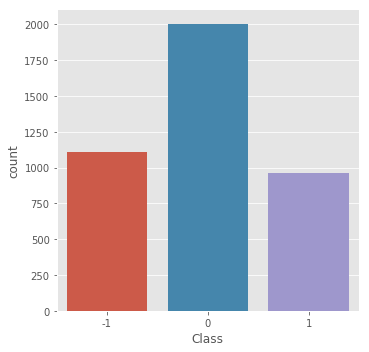

In [3]:
sns.catplot('Class',data=df1,kind="count")

In [4]:
#Por el momento no se utiliza ninguna de estas variables
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()

## Parametros

In [5]:
step=10

In [28]:
Hpyer_Parameters = [[i for i in range(2,6)], # max_depth sin embargo dada la cantidad de datos la profundidad maxima es de 5
                    [i for i in range(2,20)]] # min_samples_leaf

set_parameters = [i for i in it.product(*Hpyer_Parameters)]

Epsilon = 0.2 #error real
delta = 0.1  #error de entrenamiento

h_aprox = len(set_parameters) #hipotesis para una regresión lineal

### $\eta$ minimo estimado

In [7]:
n_est = int(np.ceil((1/Epsilon)*(np.log(len(set_parameters)) + np.log(1/delta))))
n_est

35

### $\eta$ minimo optimo

In [21]:
muestra=np.zeros(8)
num=list(range(8))
max_attributes=len(list(df1)) #esta si se usa
depth_range = range(1, max_attributes + 1)
k=5  

In [23]:
def m_opt_tree(k,delta,Epsilon,max_attributes):
            return int((np.log(2)/(2*Epsilon**2))*(((2**k)-1)*(1+np.log2(max_attributes-1))+1+np.log(1/delta)))

In [24]:
for k in range(0,8): #profundidad del arbol
    muestra[k]=(m_opt_tree(k,delta,Epsilon,max_attributes))


In [25]:
muestra #muestra minima para entrenar un arbol de las diferentes profundidades
min_n=pd.DataFrame(muestra,num)
min_n

,0
0,28.0
1,89.0
2,212.0
3,457.0
4,946.0
5,1926.0
6,3885.0
7,7803.0


Dado que mi cantidad de datos es 4075 solo puedo entregar arboles de maxima profundidad de 5. el 60% de los datos que necesito para entrenar el modelo maximo podría tomar 2455 datos, por lo que una profundidad de 6 ya no aplica.

In [83]:
#Se van a utilizar todos los datos para encontrar el mejor arbol
X1_tr, X1_ts, Y1_tr, Y1_ts = train_test_split(X, Y, test_size=0.6, train_size = 0.4,random_state=19)
X1_va, X1_ts, Y1_va, Y1_ts = train_test_split(X1_ts, Y1_ts, test_size=0.5,train_size = 0.5, random_state=19)

In [29]:
#parametros para encontrar el mejor arbol
#Profundidad=5
best_accur=np.zeros(len(set_parameters))

for i in range(len(set_parameters)):
    dtc = DecisionTreeClassifier(max_depth = set_parameters[i][0], min_samples_leaf= set_parameters[i][1], random_state=19)
    dtc.fit(X1_tr, Y1_tr)
    y_pred = dtc.predict(X1_ts)
    best_accur[i]=accuracy_score(Y1_ts, y_pred)
ind_bst = np.where(best_accur == np.amax(best_accur))[0][0]
ind_bst 
set_parameters[ind_bst]

(2, 2)

El mejor modelo tiene profundidad 2 y hojas 2

Prof=set_parameters[ind_bst][0]
n=int(muestra[set_parameters[ind_bst][0]])
n

In [30]:
accur=np.zeros(int((len(X)*0.6)/step))
Conf_Mat= np.zeros((int((len(X)*0.6)/step),3,3))
R_rta=pd.DataFrame(accur,Conf_Mat)
R_rta.all()
accur
num=list(range(len(accur)))
#Conf_Mat

In [31]:
n=int(muestra[2])
#X1_tr, X1_ts, Y1_tr, Y1_ts = train_test_split(X, Y, test_size=((n/X.shape[0])*0.4/0.6), train_size = n/X.shape[0],random_state=19)
#X1_va, X1_ts, Y1_va, Y1_ts = train_test_split(X1_ts, Y1_ts, train_size = 0.5, random_state=19)

In [32]:
N=range(n,round(len(X)*0.6),step) #round(len(X)) se multiplica por 0.6 que es el maximo de datos que puedo utilizar para
#que el modelo aprenda N[198] X.shape[0]
#N[198]/X.shape[0]*0.4/0.6+N[198]/X.shape[0]
N

range(212, 2445, 10)

In [33]:
best_dtc = DecisionTreeClassifier(max_depth = set_parameters[ind_bst][0],min_samples_leaf= set_parameters[ind_bst][1], random_state=19)
for i in range(len(N)):
    Xb_tr, Xb_o, Yb_tr, Yb_o = train_test_split(X, Y,test_size=((N[i]/X.shape[0])*0.4/0.6),train_size=N[i]/X.shape[0],random_state=19)  
    Xb_va, Xb_ts, Yb_va, Yb_ts = train_test_split(Xb_o, Yb_o, test_size=0.5, train_size = 0.5, random_state=19)                                        
    best_dtc.fit(Xb_tr, Yb_tr)
    y_pred = dtc.predict(Xb_ts)
    accur[i] = accuracy_score(Yb_ts,y_pred)
    Conf_Mat[i,:,:] = confusion_matrix(Yb_ts,y_pred)

La cantidad de datos son 4075, como se debe ir aumentando la muestra para el entrenamiento del modelo maximo esta puede llegar maximo a 2,437, que representa alrededor del 60% de los datos, de ahi en adelante no hay forma de seguir entrenando. 
El mejor accuracy está es para un tamaño de muestra de 2,227, llegando a 0.536 de ahi el modelo empieza a desmejorar.

In [34]:
max(accur)

0.5641025641025641

In [35]:
n_bst = np.where(accur == np.amax(accur))[0]
n_bst

array([2], dtype=int64)

Para el modelo escogido el mejor acuracy se da con solo 222 datos.

In [36]:
accur[n_bst]

array([0.56410256])

In [37]:
a = []
for i in range(0,244): #len(N)-1
    i=n+i*step
    a.append(i)
#print(a)

Text(0.5, 0, 'Cantidad datos')

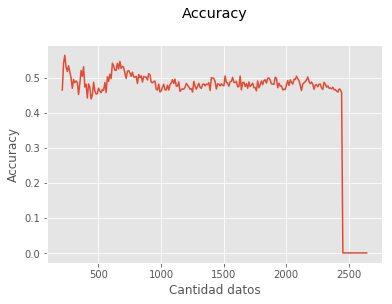

In [38]:
plt.plot(a,accur)
plt.title('Accuracy', y=1.1)
plt.ylabel('Accuracy')
plt.xlabel('Cantidad datos')

In [39]:
# precisión del modelo en datos de entrenamiento.
print("precisión entranamiento: {0: .2f}".format(best_dtc.score(Xb_tr, Yb_tr)))

precisión entranamiento:  0.52


In [40]:
# precisión del modelo en datos de evaluación.
print("precisión evaluación: {0: .2f}".format(best_dtc.score( Xb_ts, Yb_ts)))

precisión evaluación:  0.54


In [41]:
# precisión del modelo en datos de evaluación.
print("precisión evaluación: {0: .2f}".format(best_dtc.score( Xb_va, Yb_va)))

precisión evaluación:  0.51


Text(0.5, 257.44, 'Predicted label')

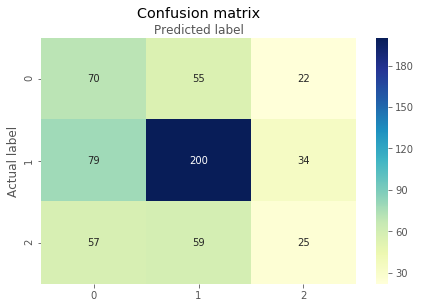

In [42]:
class_names=[-1,0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(Conf_Mat[159]), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Problema binario

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score,auc
from matplotlib import pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

In [44]:
# Binarize the output
y = label_binarize(Y, classes=[-1, 0, 1])
n_classes = y.shape[1]
n_classes

3

In [45]:
Xb_tr, Xb_o, Yb_tr, Yb_o = train_test_split(X, y,test_size=((N[int(n_bst)]/X.shape[0])*0.4/0.6),train_size=N[int(n_bst)]/X.shape[0],random_state=19)  
Xb_va, Xb_ts, Yb_va, Yb_ts = train_test_split(Xb_o, Yb_o, test_size=0.5, train_size = 0.5, random_state=19)  
Tree = DecisionTreeClassifier(max_depth = set_parameters[ind_bst][0],min_samples_leaf= set_parameters[ind_bst][1], random_state=19)
y_pred = dtc.predict(Xb_ts)
#accur= accuracy_score(Yb_ts,y_pred)
#Conf_Mat = confusion_matrix(Yb_ts,y_pred)
#np.ravel(Y)

In [47]:
# https://www.programcreek.com/python/example/94869/sklearn.multiclass.OneVsRestClassifier
classifier = OneVsRestClassifier(DecisionTreeClassifier(max_depth =2,min_samples_leaf= 2, random_state=0))
y_score = classifier.fit(Xb_tr, Yb_tr).predict_proba(Xb_ts)

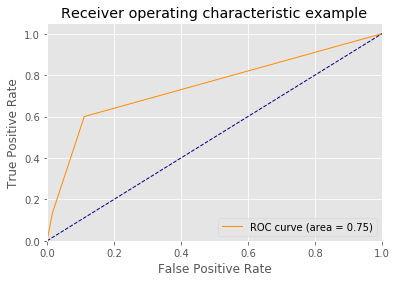

In [48]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()

roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Yb_ts[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Yb_ts.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 1
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# ROC  por clase

In [78]:
X_train, X_o, y_train, y_o = train_test_split(X, y,test_size=((N[int(n_bst)]/X.shape[0])*0.4/0.6)
                                              ,train_size=N[int(n_bst)]/X.shape[0],random_state=19)  

Xb_va, Xb_test, Yb_va, Yb_test = train_test_split(X_o, y_o, test_size=0.5, train_size = 0.5, random_state=19)  

classifier2 = OneVsRestClassifier(DecisionTreeClassifier(max_depth = set_parameters[ind_bst][0]
                                                         ,min_samples_leaf= set_parameters[ind_bst][1],random_state=0))

y_score2 = classifier2.fit(X_train, y_train).predict_proba(Xb_test)

In [79]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Yb_test[:, i], y_score2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])

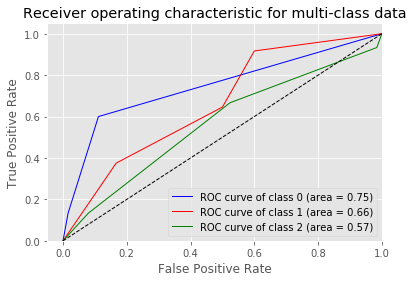

In [80]:
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# Probando escoger otro modelo

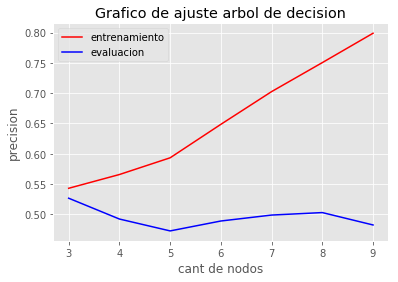

In [86]:
# Grafico de ajuste del árbol de decisión datos de la celda 8
train_prec =  []
eval_prec = []
max_deep_list = list(range(3, 10))

for deep in max_deep_list:
    arbol3 = DecisionTreeClassifier(criterion='entropy', max_depth=deep)
    arbol3.fit(X1_tr, Y1_tr)
    train_prec.append(arbol3.score(X1_tr, Y1_tr))
    eval_prec.append(arbol3.score(X1_ts, Y1_ts))

# graficar los resultados.
plt.plot(max_deep_list, train_prec, color='r', label='entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='evaluacion')
plt.title('Grafico de ajuste arbol de decision')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cant de nodos')
plt.show()

## probando otro arbol con menos hojas por la evaluación hecha

In [87]:
best_dtc3 = DecisionTreeClassifier(max_depth = 2,min_samples_leaf= 3, random_state=19)
for i in range(len(N)):
    Xb3_tr, Xb3_o, Yb3_tr, Yb3_o = train_test_split(X, Y,test_size=((N[i]/X.shape[0])*0.4/0.6),train_size=N[i]/X.shape[0],random_state=19)  
    Xb3_va, Xb3_ts, Yb3_va, Yb3_ts = train_test_split(Xb3_o, Yb3_o, test_size=0.5, train_size = 0.5, random_state=19)                                        
    best_dtc3.fit(Xb_tr, Yb_tr)
    y3_pred = dtc.predict(Xb3_ts)
    accur[i] = accuracy_score(Yb3_ts,y3_pred)
    Conf_Mat[i,:,:] = confusion_matrix(Yb3_ts,y3_pred)

In [88]:
max(accur)

0.5641025641025641

In [89]:
n_bst = np.where(accur == np.amax(accur))[0]
n_bst

array([2], dtype=int64)

## evaluando mejor cantidad de hojas para frofundidad de 5.

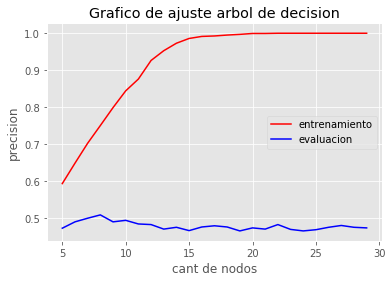

In [91]:
# Grafico de ajuste del árbol de decisión datos de la celda 8
train_prec =  []
eval_prec = []
max_deep_list = list(range(5, 30))

for deep in max_deep_list:
    arbol4 = DecisionTreeClassifier(criterion='entropy', max_depth=deep)
    arbol4.fit(X1_tr, Y1_tr)
    train_prec.append(arbol4.score(X1_tr, Y1_tr))
    eval_prec.append(arbol4.score(X1_ts, Y1_ts))

# graficar los resultados.
plt.plot(max_deep_list, train_prec, color='r', label='entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='evaluacion')
plt.title('Grafico de ajuste arbol de decision')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cant de nodos')
plt.show()

In [85]:
# utilizando validation curve de sklearn

from sklearn.model_selection import learning_curve,validation_curve
#from learning_curve import validation_curve

In [96]:
X6_tr, X6_ts = validation_curve(estimator=best_dtc, X=X1_tr,y=Y1_tr, param_name='max_depth',param_range=max_deep_list, cv=5)

train_mean = np.mean(X6_tr, axis=1)
train_std = np.std(X6_tr, axis=1)
test_mean = np.mean(X6_ts, axis=1)
test_std = np.std(X6_ts, axis=1)

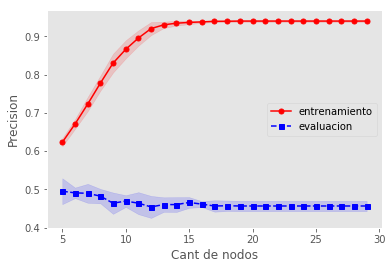

In [97]:
# graficando las curvas
plt.plot(max_deep_list, train_mean, color='r', marker='o', markersize=5,
         label='entrenamiento')
plt.fill_between(max_deep_list, train_mean + train_std, 
                 train_mean - train_std, alpha=0.15, color='r')
plt.plot(max_deep_list, test_mean, color='b', linestyle='--', 
         marker='s', markersize=5, label='evaluacion')
plt.fill_between(max_deep_list, test_mean + test_std, 
                 test_mean - test_std, alpha=0.15, color='b')
plt.grid()
plt.legend(loc='center right')
plt.xlabel('Cant de nodos')
plt.ylabel('Precision')
plt.show()